<a href="https://colab.research.google.com/github/parthrjpt/EAS555_Projects/blob/main/PS5_CSE555.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1

## Task 1-a

### Restricted Boltzmann Machine

Restricted Boltzmann Machines are the most common building blocks of Deep probabilistic models. It is a generative stochastic artificial network which is capable of learning set of probabilities given a set of inputs.
</br>
Like the Boltzmann machine, RBM is also an energy based model and the pjont probability is given by,
$$P(v=v,h=h) = \frac{1}{Z} exp(-E(v,h))$$
The energy function for this is given as:
$$E(v,h) = -b^T v - c^Th -v^TWh$$
and Z is the normalization function given by
$$Z=\sum_v\sum_h exp(-E(v,h))$$
The conditional distribution can be derived from the joint distribution as:
$$P(h|v)= \frac{P(h,v)}{P(v)}$$
$$  =\frac{1}{Z'}\prod_{i=1}^mexp(c^Th -v^TWh)$$
$$P(h_j=1|v) = \sigma (c_{j}+v^TW_j)$$
where $\sigma$ denotes the sigmoid function.
</br>*italicized text*
Conversely, we can also define $$P(v_j=1|h)$$


For Task 1-b and Task 1-c, pytorch based implementation  has been provided. The model performs poorly for 20 hidden nodes, but gives decent performance with 100 hidden nodes. The learning rate as well as epsilon which prevents issues related to divide-by-zero errors was used. The issue was most prominently observed for 500 nodes, due to which different parameter values were used.



## Task 1-b

### Defining RBM


In [ ]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

In [ ]:
class RBM(nn.Module):
   def __init__(self, visible=784, hidden=20, k=1):
        super(RBM, self).__init__()
        self.Weights = nn.Parameter(torch.randn(hidden,visible)*0.01) #weights
        self.vbias = torch.zeros(visible) #bias
        self.hbias = torch.zeros(hidden)  #bias
        self.k = k
    
   def sampler(self,p):
       return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
   #propagation from visible nodes to hidden nodes
   def  from_visible_to_hidden(self,v):
        h_activation = F.linear(v,self.Weights,self.hbias) #computes v*W+hbias
        p_h = torch.sigmoid(h_activation)
        sample_h = self.sampler(p_h)
        return p_h,sample_h
  
   #propagation from visible nodes to hidden nodes
   def from_hidden_to_visible(self,h):
        v_activation = F.linear(h,self.Weights.t(),self.vbias) #computes h*W^T+vbias
        p_v = torch.sigmoid(v_activation)
        sample_v = self.sampler(p_v)
        return p_v,sample_v
        
   def forward(self,v):
        pre_h1,h1 = self.from_visible_to_hidden(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.from_hidden_to_visible(h_)
            pre_h_,h_ = self.from_visible_to_hidden(v_)
        
        return v,v_
    
   def free_energy(self,v):
        vbias_term = v.mv(self.vbias)
        wx_b = F.linear(v,self.Weights,self.hbias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

In [ ]:
from keras.datasets import mnist
(train, y), (X_test, y_test) = mnist.load_data()

#converting keras based image data to pytorch tensor
train_loader = torch.utils.data.DataLoader(train,
    batch_size=100)


11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# train_loader = torch.utils.data.DataLoader(
# datasets.MNIST('./data',
#     train=True,
#     download = True,
#     transform = transforms.Compose(
#         [transforms.ToTensor()])
#      ),
#      batch_size=100
# )

test_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=False,
    download=True,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    ),
    batch_size=100)

# from keras.datasets import mnist
# (X, y), (X_test, y_test) = mnist.load_data()
# print(X.shape, y.shape,X_test.shape, y_test.shape)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# X = X.reshape((X.shape[0] , X.shape[1]*X.shape[2]))
# X = X.astype(np.float32)

In [ ]:
# x_train_tensor = Variable(torch.Tensor(X))

In [ ]:
# from torchvision import transforms

# transformations = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5))])

In [ ]:
#X_train_tensor = transformations(X)

In [ ]:
#20nodes
rbm = RBM(k=2,hidden=20)
train_op = optim.Adam(rbm.parameters(),lr = 0.01,eps=1e-5)

for epoch in range(20):
    loss20 = []
    for _, (data) in enumerate(train_loader):
        data = Variable(data.view(-1,784))/255 #regularizing the data to pass it directly to torch.bernoulli
        sample_data = torch.bernoulli(data)    
        pre_img,img = rbm(sample_data)
        loss = rbm.free_energy(pre_img) - rbm.free_energy(img)
        loss20.append(loss)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Current epoch: ",epoch)

Current epoch:  0
Current epoch:  1
Current epoch:  2
Current epoch:  3
Current epoch:  4
Current epoch:  5
Current epoch:  6
Current epoch:  7
Current epoch:  8
Current epoch:  9
Current epoch:  10
Current epoch:  11
Current epoch:  12
Current epoch:  13
Current epoch:  14
Current epoch:  15
Current epoch:  16
Current epoch:  17
Current epoch:  18
Current epoch:  19


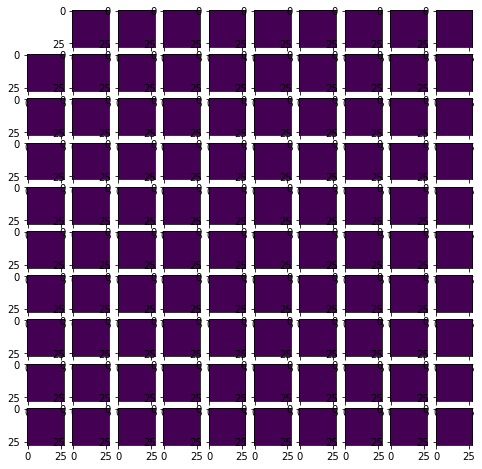

In [ ]:
fig=plt.figure(figsize=(8, 8))
for i in range(1,100):
    image=img[i].detach().numpy()
    image = image.reshape(28,28)
    fig.add_subplot(10, 10, i+1)
    plt.imshow(image)
plt.show()

In [ ]:
#100nodes
rbm100 = RBM(k=2,hidden=100)
train_op = optim.Adam(rbm100.parameters(),lr = 0.01,eps=1e-5)

for epoch in range(20):
    loss100 = []
    for _, (data) in enumerate(train_loader):
        data = Variable(data.view(-1,784))/255
        sample_data = torch.bernoulli(data)    
        pre_img,img = rbm100(sample_data)
        loss = rbm100.free_energy(pre_img) - rbm100.free_energy(img)
        train_op.zero_grad()
        loss100.append(loss)
        loss.backward()
        train_op.step()

    print("Current epoch: ",epoch)

Current epoch:  0
Current epoch:  1
Current epoch:  2
Current epoch:  3
Current epoch:  4
Current epoch:  5
Current epoch:  6
Current epoch:  7
Current epoch:  8
Current epoch:  9
Current epoch:  10
Current epoch:  11
Current epoch:  12
Current epoch:  13
Current epoch:  14
Current epoch:  15
Current epoch:  16
Current epoch:  17
Current epoch:  18
Current epoch:  19


In [ ]:
loss100

[tensor(6.9122, grad_fn=<SubBackward0>),
 tensor(2.3783, grad_fn=<SubBackward0>),
 tensor(4.8531, grad_fn=<SubBackward0>),
 tensor(3.8200, grad_fn=<SubBackward0>),
 tensor(8.8929, grad_fn=<SubBackward0>),
 tensor(6.2960, grad_fn=<SubBackward0>),
 tensor(2.0416, grad_fn=<SubBackward0>),
 tensor(2.8547, grad_fn=<SubBackward0>),
 tensor(1.5710, grad_fn=<SubBackward0>),
 tensor(0.6358, grad_fn=<SubBackward0>),
 tensor(9.7563, grad_fn=<SubBackward0>),
 tensor(6.8276, grad_fn=<SubBackward0>),
 tensor(1.8254, grad_fn=<SubBackward0>),
 tensor(0.5016, grad_fn=<SubBackward0>),
 tensor(1.6475, grad_fn=<SubBackward0>),
 tensor(1.2125, grad_fn=<SubBackward0>),
 tensor(2.2122, grad_fn=<SubBackward0>),
 tensor(-2.4243, grad_fn=<SubBackward0>),
 tensor(0.5999, grad_fn=<SubBackward0>),
 tensor(1.2296, grad_fn=<SubBackward0>),
 tensor(1.7131, grad_fn=<SubBackward0>),
 tensor(0.7775, grad_fn=<SubBackward0>),
 tensor(-0.3552, grad_fn=<SubBackward0>),
 tensor(0.0978, grad_fn=<SubBackward0>),
 tensor(2.7472

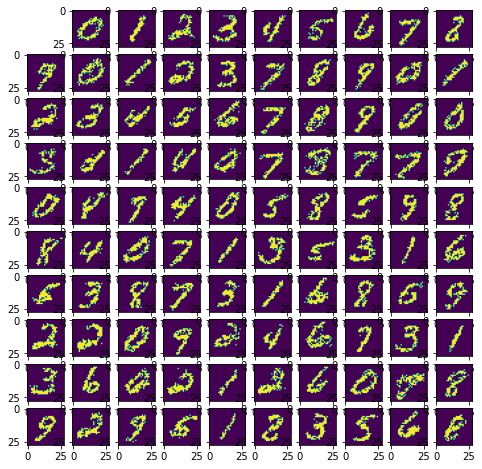

In [ ]:
fig=plt.figure(figsize=(8, 8))
for i in range(1,100):
    image=img[i].detach().numpy()
    image = image.reshape(28,28)
    fig.add_subplot(10, 10, i+1)
    plt.imshow(image)
plt.show()

In [ ]:
#500nodes
rbm500 = RBM(k=2,hidden=500)
train_op = optim.Adam(rbm500.parameters(),lr = 0.0001,eps=1e-8)

for epoch in range(20):
    loss500 = []
    for _, (data) in enumerate(train_loader):
        data = Variable(data.view(-1,784))/255
        sample_data = torch.bernoulli(data)    
        pre_img,img = rbm500(sample_data)
        loss = rbm500.free_energy(pre_img) - rbm500.free_energy(img)
        loss500.append(loss)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Current epoch: ",epoch)

Current epoch:  0
Current epoch:  1
Current epoch:  2
Current epoch:  3
Current epoch:  4
Current epoch:  5
Current epoch:  6
Current epoch:  7
Current epoch:  8
Current epoch:  9
Current epoch:  10
Current epoch:  11
Current epoch:  12
Current epoch:  13
Current epoch:  14
Current epoch:  15
Current epoch:  16
Current epoch:  17
Current epoch:  18
Current epoch:  19


In [ ]:
loss500

[tensor(-11.4964, grad_fn=<SubBackward0>),
 tensor(-12.1361, grad_fn=<SubBackward0>),
 tensor(-11.8834, grad_fn=<SubBackward0>),
 tensor(-14.0411, grad_fn=<SubBackward0>),
 tensor(-10.5352, grad_fn=<SubBackward0>),
 tensor(-7.2363, grad_fn=<SubBackward0>),
 tensor(-12.2616, grad_fn=<SubBackward0>),
 tensor(-14.6929, grad_fn=<SubBackward0>),
 tensor(-14.4062, grad_fn=<SubBackward0>),
 tensor(-12.8343, grad_fn=<SubBackward0>),
 tensor(-9.3818, grad_fn=<SubBackward0>),
 tensor(-7.9457, grad_fn=<SubBackward0>),
 tensor(-13.7488, grad_fn=<SubBackward0>),
 tensor(-15.4635, grad_fn=<SubBackward0>),
 tensor(-12.9830, grad_fn=<SubBackward0>),
 tensor(-11.1046, grad_fn=<SubBackward0>),
 tensor(-13.2413, grad_fn=<SubBackward0>),
 tensor(-14.4822, grad_fn=<SubBackward0>),
 tensor(-13.4169, grad_fn=<SubBackward0>),
 tensor(-13.1569, grad_fn=<SubBackward0>),
 tensor(-13.2905, grad_fn=<SubBackward0>),
 tensor(-14.5540, grad_fn=<SubBackward0>),
 tensor(-13.4244, grad_fn=<SubBackward0>),
 tensor(-13.06

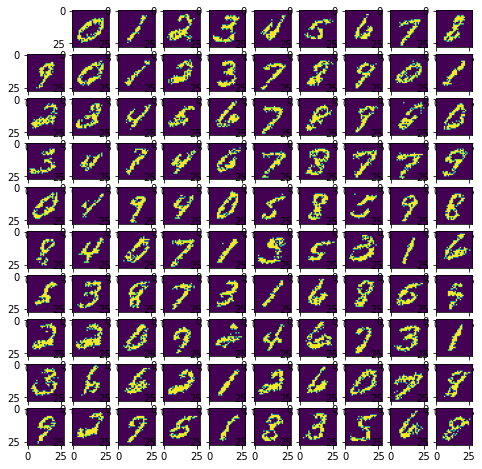

In [ ]:
fig=plt.figure(figsize=(8, 8))
for i in range(1,100):
    image=img[i].detach().numpy()
    image = image.reshape(28,28)
    fig.add_subplot(10, 10, i+1)
    plt.imshow(image)
plt.show()

In [ ]:
#Comparative implementation with sklearn
# from sklearn.neural_network import BernoulliRBM

In [ ]:
# learning_rate=0.1
# batch_size=100
# epochs=50
# rbm20 = BernoulliRBM(n_components=20,learning_rate=learning_rate, batch_size=batch_size, 
#                                 n_iter=epochs,verbose=1)
# rbm100 = BernoulliRBM(n_components=100,learning_rate=learning_rate, batch_size=batch_size, 
#                                 n_iter=epochs,verbose=1)
# rbm500 = BernoulliRBM(n_components=500,learning_rate=learning_rate, batch_size=batch_size, 
#                                 n_iter=epochs,verbose=1)

In [ ]:
# X_train = X.astype('float32') / 255
# X_test = X_test.astype('float32') / 255
# X_train=X_train.reshape(60000,784)
# X_test=X_test.reshape(10000,784)

In [ ]:
# rbm20.fit(X_train)
# degrade20 = rbm20.gibbs(X_test)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -187.11, time = 3.22s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -183.91, time = 3.85s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -186.73, time = 3.79s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -184.36, time = 3.85s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -181.90, time = 3.80s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -176.97, time = 3.79s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -173.43, time = 3.78s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -172.51, time = 3.72s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -164.69, time = 3.75s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -162.39, time = 3.83s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -163.11, time = 3.75s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -157.97, time = 3.81s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -158.28, time = 3.78s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -159.08, time = 3.78s
[BernoulliRBM] 

In [ ]:
# rbm100.fit(X_train)
# degrade100 = rbm100.gibbs(X_test)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -122.54, time = 5.24s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -110.31, time = 6.67s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -100.63, time = 6.60s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -97.71, time = 6.51s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -94.77, time = 6.62s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -92.81, time = 6.74s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -90.88, time = 7.11s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -91.95, time = 6.78s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -89.91, time = 6.73s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -91.02, time = 6.64s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -88.57, time = 6.65s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -88.08, time = 6.47s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -88.77, time = 6.38s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -85.43, time = 6.39s
[BernoulliRBM] Iteration 1

In [ ]:
# rbm500.fit(X_train)
# degrade500 = rbm500.gibbs(X_test)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -107.47, time = 14.61s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -92.35, time = 19.11s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -80.73, time = 19.04s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -78.94, time = 19.05s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -75.30, time = 19.14s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -73.31, time = 19.05s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -71.38, time = 18.88s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -72.29, time = 18.85s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -69.82, time = 18.95s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -69.40, time = 18.70s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -69.45, time = 18.77s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -69.86, time = 18.86s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -69.44, time = 18.90s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -68.41, time = 18.90s
[BernoulliRBM]

In [ ]:
# degrade20_train = rbm20.gibbs(X_train[0:100])
# degrade100_train = rbm100.gibbs(X_train[0:100])
# degrade500_train = rbm500.gibbs(X_train[0:100])

In [ ]:
# degrade20_train =  np.array(degrade20_train).reshape(len(degrade20_train),28,28)
# degrade100_train = np.array(degrade100_train).reshape(len(degrade100_train),28,28)
# degrade500_train = np.array(degrade500_train).reshape(len(degrade500_train),28,28)

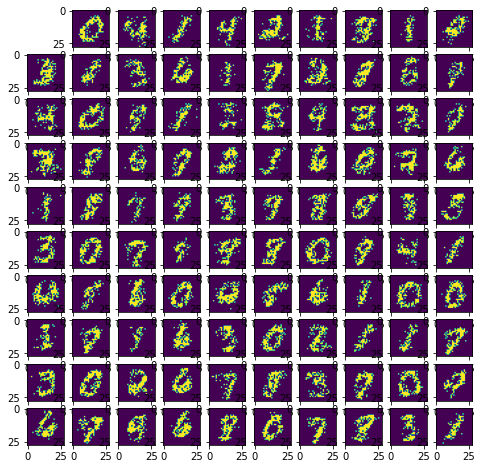

In [ ]:
# fig=plt.figure(figsize=(8, 8))
# for i in range(1,100):
#     img = degrade20_train[i].reshape((28, 28))
#     fig.add_subplot(10, 10, i+1)
#     plt.imshow(img)
# plt.show()

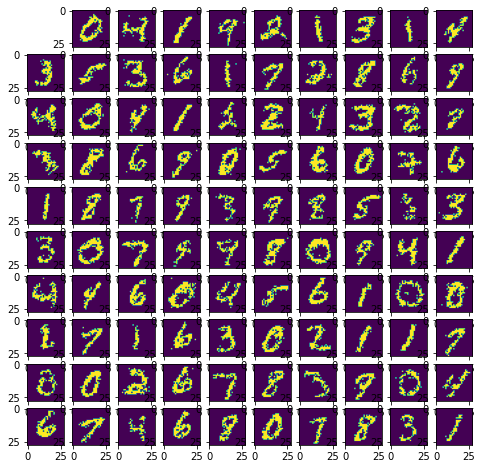

In [ ]:
# fig=plt.figure(figsize=(8, 8))
# for i in range(1,100):
#     img = degrade100_train[i].reshape((28, 28))
#     fig.add_subplot(10, 10, i+1)
#     plt.imshow(img)
# plt.show()

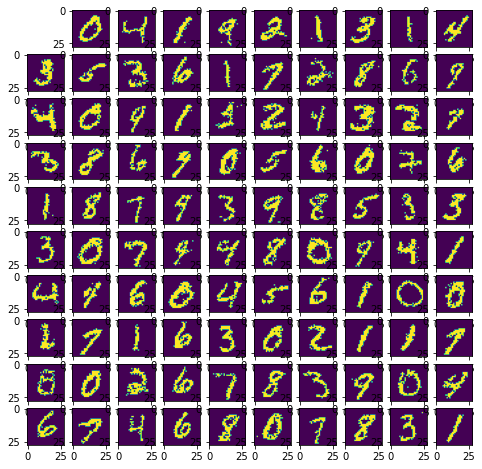

In [ ]:
# fig=plt.figure(figsize=(8, 8))
# for i in range(1,100):
#     img = degrade500_train[i].reshape((28, 28))
#     fig.add_subplot(10, 10, i+1)
#     plt.imshow(img)
# plt.show()

## Task 1-c


In [ ]:
from torchvision import transforms as transforms

# Degrading data by randomly blackening a set of pixels
def data_degrade(test_loader,percent=20):
  test_data = np.array(test_loader.dataset.data).reshape(10000,784)
  n=int(len(test_data)*percent/100)
  indices = np.random.choice(len(test_data),n)
  test_data[indices]=0
  test_data = test_data.reshape(len(test_data),28,28)
  
  reconvert_data = Variable(torch.Tensor(test_data))
  return reconvert_data

In [ ]:
#20% pixel removal
test=data_degrade(test_loader,percent=20)
test_loader = torch.utils.data.DataLoader(test,
    batch_size=100)
  
rbm500 = RBM(k=2,n_hin=500)
train_op = optim.Adam(rbm500.parameters(),lr = 0.0001,eps=1e-8)

for epoch in range(20):
    loss500 = []
    for _, data in enumerate(test_loader):
        data = Variable(data.view(-1,784))/255
        sample_data = torch.bernoulli(data)    
        pre_img,img = rbm500(sample_data)
        loss = rbm500.free_energy(pre_img) - rbm500.free_energy(img)
        loss500.append(loss)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Current epoch: ",epoch)

Current epoch:  0
Current epoch:  1
Current epoch:  2
Current epoch:  3
Current epoch:  4
Current epoch:  5
Current epoch:  6
Current epoch:  7
Current epoch:  8
Current epoch:  9
Current epoch:  10
Current epoch:  11
Current epoch:  12
Current epoch:  13
Current epoch:  14
Current epoch:  15
Current epoch:  16
Current epoch:  17
Current epoch:  18
Current epoch:  19


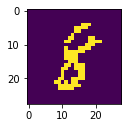

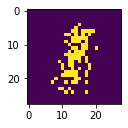

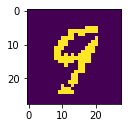

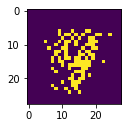

In [ ]:
fig=plt.figure(figsize=(8, 8))
image=pre_img[0].detach().numpy()
image = image.reshape(28,28)
fig.add_subplot(4, 4, 1)
plt.imshow(image)
fig=plt.figure(figsize=(8, 8))
image=img[0].detach().numpy()
image = image.reshape(28,28)
fig.add_subplot(4, 4, 2)
plt.imshow(image)
fig=plt.figure(figsize=(8, 8))
image=pre_img[1].detach().numpy()
image = image.reshape(28,28)
fig.add_subplot(4, 4, 3)
plt.imshow(image)
fig=plt.figure(figsize=(8, 8))
image=img[1].detach().numpy()
image = image.reshape(28,28)
fig.add_subplot(4, 4, 4)
plt.imshow(image)
plt.show()

In [ ]:
#50%pixel removal
test=data_degrade(test_loader,percent=50)
test_loader = torch.utils.data.DataLoader(test,
    batch_size=100)
  
rbm500 = RBM(k=2,n_hin=500)
train_op = optim.Adam(rbm500.parameters(),lr = 0.0001,eps=1e-8)

for epoch in range(20):
    loss500 = []
    for _, data in enumerate(test_loader):
        data = Variable(data.view(-1,784))/255
        sample_data = torch.bernoulli(data)    
        pre_img,img = rbm500(sample_data)
        loss = rbm500.free_energy(pre_img) - rbm500.free_energy(img)
        loss500.append(loss)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Current epoch: ",epoch)

Current epoch:  0
Current epoch:  1
Current epoch:  2
Current epoch:  3
Current epoch:  4
Current epoch:  5
Current epoch:  6
Current epoch:  7
Current epoch:  8
Current epoch:  9
Current epoch:  10
Current epoch:  11
Current epoch:  12
Current epoch:  13
Current epoch:  14
Current epoch:  15
Current epoch:  16
Current epoch:  17
Current epoch:  18
Current epoch:  19


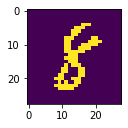

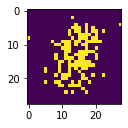

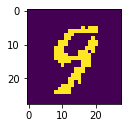

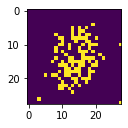

In [ ]:
fig=plt.figure(figsize=(8, 8))
image=pre_img[0].detach().numpy()
image = image.reshape(28,28)
fig.add_subplot(4, 4, 1)
plt.imshow(image)
fig=plt.figure(figsize=(8, 8))
image=img[0].detach().numpy()
image = image.reshape(28,28)
fig.add_subplot(4, 4, 2)
plt.imshow(image)
fig=plt.figure(figsize=(8, 8))
image=pre_img[1].detach().numpy()
image = image.reshape(28,28)
fig.add_subplot(4, 4, 3)
plt.imshow(image)
fig=plt.figure(figsize=(8, 8))
image=img[1].detach().numpy()
image = image.reshape(28,28)
fig.add_subplot(4, 4, 4)
plt.imshow(image)
plt.show()

In [ ]:
#80% pixel removal
test=data_degrade(test_loader,percent=80)
test_loader = torch.utils.data.DataLoader(test,
    batch_size=100)
  
rbm500 = RBM(k=2,n_hin=500)
train_op = optim.Adam(rbm500.parameters(),lr = 0.0001,eps=1e-8)

for epoch in range(20):
    loss500 = []
    for _, data in enumerate(test_loader):
        data = Variable(data.view(-1,784))/255
        sample_data = torch.bernoulli(data)    
        pre_img,img = rbm500(sample_data)
        loss = rbm500.free_energy(pre_img) - rbm500.free_energy(img)
        loss500.append(loss)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Current epoch: ",epoch)

Current epoch:  0
Current epoch:  1
Current epoch:  2
Current epoch:  3
Current epoch:  4
Current epoch:  5
Current epoch:  6
Current epoch:  7
Current epoch:  8
Current epoch:  9
Current epoch:  10
Current epoch:  11
Current epoch:  12
Current epoch:  13
Current epoch:  14
Current epoch:  15
Current epoch:  16
Current epoch:  17
Current epoch:  18
Current epoch:  19


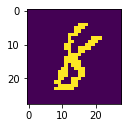

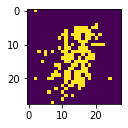

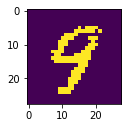

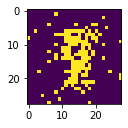

In [ ]:
fig=plt.figure(figsize=(8, 8))
image=pre_img[0].detach().numpy()
image = image.reshape(28,28)
fig.add_subplot(4, 4, 1)
plt.imshow(image)
fig=plt.figure(figsize=(8, 8))
image=img[0].detach().numpy()
image = image.reshape(28,28)
fig.add_subplot(4, 4, 2)
plt.imshow(image)
fig=plt.figure(figsize=(8, 8))
image=pre_img[1].detach().numpy()
image = image.reshape(28,28)
fig.add_subplot(4, 4, 3)
plt.imshow(image)
fig=plt.figure(figsize=(8, 8))
image=img[1].detach().numpy()
image = image.reshape(28,28)
fig.add_subplot(4, 4, 4)
plt.imshow(image)
plt.show()

# Task 2

## Task 2-a

### Varitional Auto Encoder

A variational Autoencoder has two networks. The first network encodes a data sample x to a latent representation z, while the second network decodes its back to dataspace:
$$z = Enc(x) =q(z|x)$$
and,
$$x= Dec(z) = p(x|z)$$

The marginal likihood is given as the sum of marginal likelihoods over individual datapoints as:
$$
log \;{p_{\theta}}(x^i) =  D_{KL}(q_\phi(z|x^i)||{p_{\theta}(z|x^i)})+ \mathcal L(\theta,\phi;x^i)$$

## Task 2-b

In [ ]:
import tensorflow  as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras import backend as K

In [ ]:
from keras.datasets import mnist
(X, y), (X_test, y_test) = mnist.load_data()


In [ ]:
X_train = X.reshape(len(X),784)
X_test = X_test.reshape(len(X_test),784)

In [ ]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [ ]:
def compute_loss(y,y_pred):
  loss =  K.sum(K.binary_crossentropy(y, y_pred), axis=-1)
  return loss

In [ ]:
# input_l=Input(shape=(784,))

# encoding=Dense(256, activation='relu')(input_l)
# bottleneck=Dense(2, activation='relu')(encoding)
# decoding=Dense(256, activation='relu')(bottleneck)
# output_l=Dense(784, activation='sigmoid')(decoding)

# autoencoder=Model(inputs=[input_l],outputs=[output_l])

inputs = Input(shape=(784,))
h = Dense(256, activation='relu')(inputs)
z_mean=Dense(2, activation='relu')(h)
z_log_sigma = Dense(2)(h)
epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 2),
                              mean=0., stddev=0.1)
z= z_mean + K.exp(z_log_sigma) * epsilon
encoder = Model(inputs, [z_mean, z_log_sigma, z])
latent_inputs = Input(shape=(2,))
decoding = Dense(256, activation='relu')(latent_inputs)
decoding = Dense(784, activation='relu')(decoding)
decoder = Model(latent_inputs, decoding, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.compile(optimizer='rmsprop', loss= compute_loss)
hist = vae.fit(X_train, X_train, shuffle=True, epochs=10, batch_size=100, validation_data=(X_test, X_test))

Epoch 1/10
600/600 [==============================] - 7s 10ms/step - loss: 327.0993 - val_loss: 259.0432
Epoch 2/10
600/600 [==============================] - 6s 10ms/step - loss: 257.6030 - val_loss: 254.6100
Epoch 3/10
600/600 [==============================] - 6s 10ms/step - loss: 254.7831 - val_loss: 253.4603
Epoch 4/10
600/600 [==============================] - 6s 10ms/step - loss: 254.0717 - val_loss: 252.2225
Epoch 5/10
600/600 [==============================] - 6s 10ms/step - loss: 253.5463 - val_loss: 252.7221
Epoch 6/10
600/600 [==============================] - 6s 10ms/step - loss: 249.2713 - val_loss: 244.8336
Epoch 7/10
600/600 [==============================] - 6s 10ms/step - loss: 245.2820 - val_loss: 243.6825
Epoch 8/10
600/600 [==============================] - 6s 10ms/step - loss: 244.0547 - val_loss: 243.7044
Epoch 9/10
600/600 [==============================] - 6s 10ms/step - loss: 243.3845 - val_loss: 241.9130
Epoch 10/10
600/600 [==============================] - 

In [ ]:
y_pred= vae.predict(X_test[0:10])

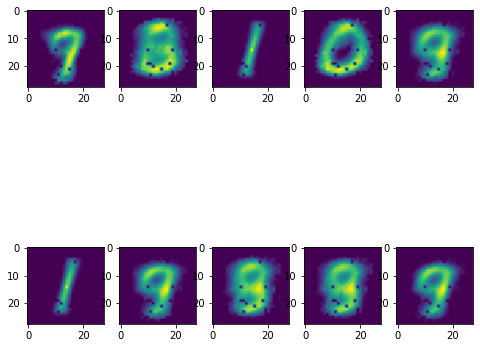

In [ ]:
fig=plt.figure(figsize=(8, 8))
for i in range(len(y_pred)):
    image = y_pred[i].reshape(28,28)
    fig.add_subplot(2, 5, i+1)
    plt.imshow(image)
plt.show()

In [ ]:
inputs = Input(shape=(784,))
h = Dense(256, activation='relu')(inputs)
z_mean=Dense(8, activation='relu')(h)
z_log_sigma = Dense(8)(h)
epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 8),
                              mean=0., stddev=0.1)
z= z_mean + K.exp(z_log_sigma) * epsilon
encoder = Model(inputs, [z_mean, z_log_sigma, z])
latent_inputs = Input(shape=(8,))
decoding = Dense(256, activation='relu')(latent_inputs)
decoding = Dense(784, activation='relu')(decoding)
decoder = Model(latent_inputs, decoding, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.compile(optimizer='rmsprop', loss= compute_loss)
hist = vae.fit(X_train, X_train, shuffle=True, epochs=10, batch_size=100, validation_data=(X_test, X_test))

Epoch 1/10
600/600 [==============================] - 7s 10ms/step - loss: 262.0742 - val_loss: 186.2680
Epoch 2/10
600/600 [==============================] - 6s 10ms/step - loss: 186.9267 - val_loss: 171.4339
Epoch 3/10
600/600 [==============================] - 6s 9ms/step - loss: 174.6738 - val_loss: 171.6592
Epoch 4/10
600/600 [==============================] - 6s 9ms/step - loss: 174.9998 - val_loss: 170.8625
Epoch 5/10
600/600 [==============================] - 6s 9ms/step - loss: 174.7632 - val_loss: 189.2425
Epoch 6/10
600/600 [==============================] - 6s 10ms/step - loss: 175.4890 - val_loss: 177.6458
Epoch 7/10
600/600 [==============================] - 6s 10ms/step - loss: 175.2819 - val_loss: 169.2214
Epoch 8/10
600/600 [==============================] - 6s 10ms/step - loss: 169.6704 - val_loss: 166.1361
Epoch 9/10
600/600 [==============================] - 6s 10ms/step - loss: 172.9550 - val_loss: 171.3329
Epoch 10/10
600/600 [==============================] - 6s 

In [ ]:
y_pred= vae.predict(X_test[0:10])

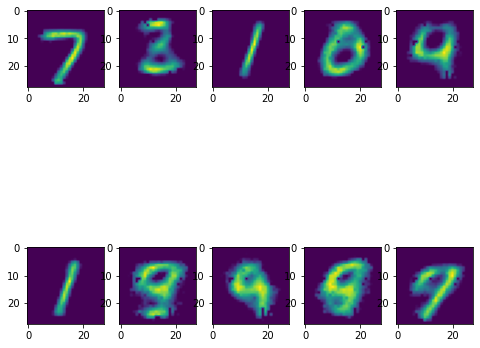

In [ ]:
fig=plt.figure(figsize=(8, 8))
for i in range(len(y_pred)):
    image = y_pred[i].reshape(28,28)
    fig.add_subplot(2, 5, i+1)
    plt.imshow(image)
plt.show()

In [ ]:
inputs = Input(shape=(784,))
h = Dense(256, activation='relu')(inputs)
z_mean=Dense(16, activation='relu')(h)
z_log_sigma = Dense(16)(h)
epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 16),
                              mean=0., stddev=0.1)
z= z_mean + K.exp(z_log_sigma) * epsilon
encoder = Model(inputs, [z_mean, z_log_sigma, z])
latent_inputs = Input(shape=(16,))
decoding = Dense(256, activation='relu')(latent_inputs)
decoding = Dense(784, activation='relu')(decoding)
decoder = Model(latent_inputs, decoding, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.compile(optimizer='rmsprop', loss= compute_loss)
hist = vae.fit(X_train, X_train, shuffle=True, epochs=10, batch_size=100, validation_data=(X_test, X_test))

Epoch 1/10
600/600 [==============================] - 7s 10ms/step - loss: 266.9805 - val_loss: 189.3134
Epoch 2/10
600/600 [==============================] - 6s 10ms/step - loss: 192.9727 - val_loss: 186.8516
Epoch 3/10
600/600 [==============================] - 6s 10ms/step - loss: 189.1683 - val_loss: 196.3889
Epoch 4/10
600/600 [==============================] - 6s 10ms/step - loss: 185.5227 - val_loss: 178.1882
Epoch 5/10
600/600 [==============================] - 6s 10ms/step - loss: 182.1308 - val_loss: 206.2949
Epoch 6/10
600/600 [==============================] - 6s 10ms/step - loss: 186.3680 - val_loss: 190.0531
Epoch 7/10
600/600 [==============================] - 6s 10ms/step - loss: 186.8564 - val_loss: 181.3020
Epoch 8/10
600/600 [==============================] - 6s 10ms/step - loss: 188.9463 - val_loss: 183.6696
Epoch 9/10
600/600 [==============================] - 6s 10ms/step - loss: 186.4337 - val_loss: 181.2745
Epoch 10/10
600/600 [==============================] - 

In [ ]:
y_pred= vae.predict(X_test[0:10])

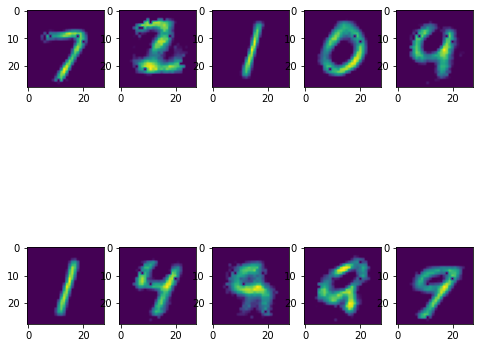

In [ ]:
fig=plt.figure(figsize=(8, 8))
for i in range(len(y_pred)):
    image = y_pred[i].reshape(28,28)
    fig.add_subplot(2, 5, i+1)
    plt.imshow(image)
plt.show()

## Task 2-c

In [ ]:
inputs = Input(shape=(784,))
h = Dense(256, activation='relu')(inputs)
z_mean=Dense(2, activation='relu')(h)
z_log_sigma = Dense(2)(h)
epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 2),
                              mean=0., stddev=0.1)
z= z_mean + K.exp(z_log_sigma) * epsilon
encoder = Model(inputs, [z_mean, z_log_sigma, z])
latent_inputs =Input(shape=(2,))
decoding = Dense(256, activation='relu')(latent_inputs)
decoding = Dense(784, activation='relu')(decoding)
decoder = Model(latent_inputs, decoding, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.compile(optimizer='rmsprop', loss= compute_loss)
hist = vae.fit(X_train, X_train, shuffle=True, epochs=10, batch_size=100, validation_data=(X_test, X_test))

Epoch 1/10
600/600 [==============================] - 7s 10ms/step - loss: 538.7136 - val_loss: 508.4477
Epoch 2/10
600/600 [==============================] - 6s 9ms/step - loss: 498.8235 - val_loss: 493.1147
Epoch 3/10
600/600 [==============================] - 6s 9ms/step - loss: 486.2377 - val_loss: 469.7158
Epoch 4/10
600/600 [==============================] - 6s 9ms/step - loss: 459.9100 - val_loss: 452.4624
Epoch 5/10
600/600 [==============================] - 6s 10ms/step - loss: 441.6281 - val_loss: 424.7379
Epoch 6/10
600/600 [==============================] - 6s 10ms/step - loss: 416.8952 - val_loss: 415.7012
Epoch 7/10
600/600 [==============================] - 6s 10ms/step - loss: 410.2700 - val_loss: 409.2039
Epoch 8/10
600/600 [==============================] - 6s 10ms/step - loss: 400.9746 - val_loss: 396.8100
Epoch 9/10
600/600 [==============================] - 6s 10ms/step - loss: 390.8186 - val_loss: 386.3703
Epoch 10/10
600/600 [==============================] - 6s 

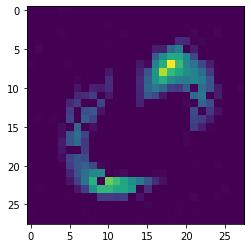

In [ ]:
input = np.array([[-1, -2]])
decoded_op = decoder.predict(input)
fig=plt.figure(figsize=(4, 4))
plt.imshow(decoded_op.reshape(28,28))
plt.show()

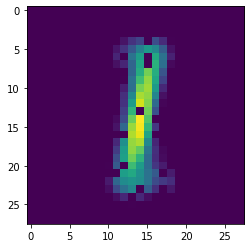

In [ ]:
input = np.array([[0, 1]])
decoded_op = decoder.predict(input)
fig=plt.figure(figsize=(4, 4))
plt.imshow(decoded_op.reshape(28,28))
plt.show()


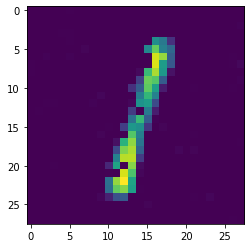

In [ ]:
input = np.array([[-1, 2]])
decoded_op = decoder.predict(input)
fig=plt.figure(figsize=(4, 4))
plt.imshow(decoded_op.reshape(28,28))
plt.show()

# Task 3

In [ ]:
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,Reshape,Flatten
from keras.utils import to_categorical

In [ ]:
from keras.datasets import mnist
(X, y), (X_test, y_test) = mnist.load_data()

X_train = X.reshape((X.shape[0], 28, 28,1))
X_test = X_test.reshape((X_test.shape[0], 28, 28,1))

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train = X/255
X_test = X_test/255

In [ ]:
inputs = Input(shape=(28,28,1), name='encoder_input')
conv1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=(28,28,1))(inputs)
conv2 = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(conv1)
flatten = Flatten()(conv2)
h = Dense(256, activation='relu')(flatten)
z_mean=Dense(16, activation='relu')(h)
z_log_sigma = Dense(16)(h)
epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 16),
                              mean=0., stddev=0.1)
z= z_mean + K.exp(z_log_sigma) * epsilon
encoder = Model(inputs, [z_mean, z_log_sigma, z])
latent_inputs = Input(shape=(16,))
dense = Dense(14*14*16,activation='relu')(latent_inputs)
reshape = Reshape((14,14,16))(dense)
deconv1 =  Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same')(reshape)
deconv2 =  Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(deconv1)
decoding = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(deconv2)
decoder = Model(latent_inputs, decoding, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.compile(optimizer='rmsprop', loss= compute_loss)
hist = vae.fit(X_train, X_train, shuffle=True, epochs=10, batch_size=100, validation_data=(X_test, X_test))

Epoch 1/10
600/600 [==============================] - 42s 15ms/step - loss: 6.4597 - val_loss: 0.1158
Epoch 2/10
600/600 [==============================] - 9s 14ms/step - loss: 3.2475 - val_loss: 0.1040
Epoch 3/10
600/600 [==============================] - 9s 14ms/step - loss: 3.0195 - val_loss: 0.1056
Epoch 4/10
600/600 [==============================] - 9s 14ms/step - loss: 2.9057 - val_loss: 0.0993
Epoch 5/10
600/600 [==============================] - 8s 14ms/step - loss: 2.8382 - val_loss: 0.0967
Epoch 6/10
600/600 [==============================] - 9s 14ms/step - loss: 2.7868 - val_loss: 0.0956
Epoch 7/10
600/600 [==============================] - 9s 14ms/step - loss: 2.7465 - val_loss: 0.0958
Epoch 8/10
600/600 [==============================] - 8s 14ms/step - loss: 2.7125 - val_loss: 0.0955
Epoch 9/10
600/600 [==============================] - 8s 14ms/step - loss: 2.6907 - val_loss: 0.0949
Epoch 10/10
600/600 [==============================] - 9s 14ms/step - loss: 2.6779 - val_l

In [ ]:
y_pred= vae.predict(X_test[0:10])

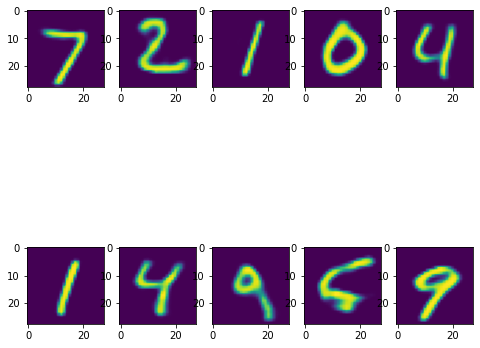

In [ ]:
fig=plt.figure(figsize=(8, 8))
for i in range(len(y_pred)):
    image = y_pred[i].reshape(28,28)
    fig.add_subplot(2, 5, i+1)
    plt.imshow(image)
plt.show()

# References

[1] Ian Goodfellow, Yoshua Bengio, & Aaron Courville (2016). Deep Learning. MIT Press.
</br>
[2]   Anders Boesen Lindbo Larsen, Søren Kaae Sønderby, Hugo Larochelle, & Ole Winther. (2016). Autoencoding beyond pixels using a learned similarity metric.</br>
[3] Diederik P Kingma, & Max Welling. (2014). Auto-Encoding Variational Bayes.</br>
Lecture Slides and tutorials referred.
